In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast/uncertainty


In [2]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

import wandb
from wandb.keras import WandbCallback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger
from model_builder import get_pinball_losses, get_simple_dist_model, get_simple_dense_model
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model
from preprocess import preprocess, get_features, pandas_cat_data


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Optimise MLP - level 10

In [5]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [6]:
level = 10

model_dir = 'models/uncertainty/hyper_opt/level_{}/'.format(level)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Read data

In [7]:
if level != 12:
    fn = data_dir + 'prep/level_{}_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle'.format(level)
else:
    fn = data_dir + 'prep/level_{}_simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle'.format(level)

# check if already preprocessed
if os.path.exists(fn):
    data = pd.read_pickle(fn)
else:
    # choose number of years to include
    if level != 12:
        n_years = 6  # all
    else:
        n_years = 2
    
    # preform preprocessing
    data = preprocess(level=level, n_years=n_years, save_prepared_dataset=True, data_dir=data_dir)
    
# set categorical features
data, available_cat_features = pandas_cat_data(data)

# select features
sell_price_features = ('sell_price' in data.columns)
features = get_features(level=level, sell_price_features=sell_price_features)
print(features)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Mem. usage decreased to 11.22 Mb (74.8% reduction)
3049 28
Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to 11.16 Mb (0.5% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)
Melted sales train validation has 5832737 rows and 6 columns
Selecting 6677310 rows (114.5%)
Mem. usage decreased to 483.94 Mb (0.0% reduction)
Saving to file..
Finished.
['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_skew_t30', 'rolling_k

In [8]:
# Set the NaNs in these categories as a single element
for col in ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']:
    data[col] = data[col].cat.add_categories(-1).fillna(-1)

In [9]:
# re-index the categories to match the input of the Embedding layer
for col in available_cat_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [10]:
# re-set the categories as pandas categories for proper pd.get_dummies
for col in available_cat_features:
    data[col] = data[col].astype('category')

## Setup training

In [11]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [12]:
def get_generators(batch_size=1024):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

## Train Dist(256) model

In [13]:
# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=256)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
model.summary()
logger = Logger(val_batch_creator)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3237)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          828928      input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          65792       dense_1[0][0]                    
______________________________________________________________________________________________

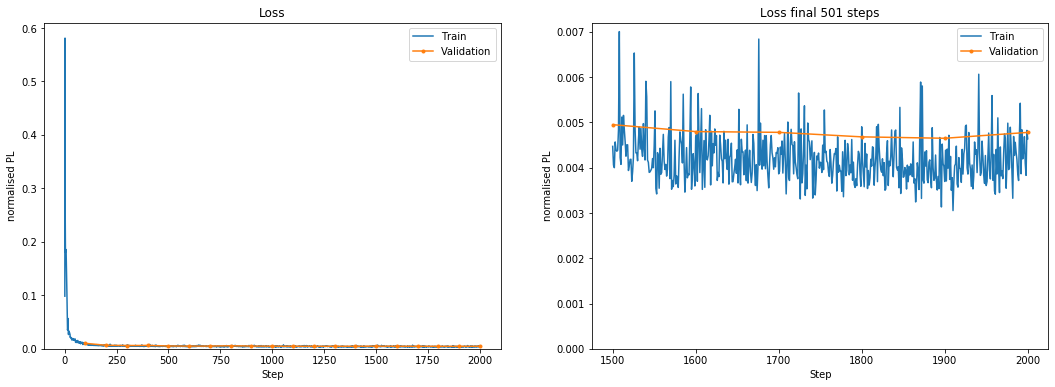

100/100 [==============================] - 69s 686ms/step - loss: 0.0042 - q0_loss: 3.8862e-05 - q1_loss: 1.4018e-04 - q2_loss: 5.5599e-04 - q3_loss: 7.0519e-04 - q4_loss: 9.1524e-04 - q5_loss: 8.1031e-04 - q6_loss: 6.7403e-04 - q7_loss: 2.3018e-04 - q8_loss: 1.0206e-04 - val_loss: 0.0048 - val_q0_loss: 4.3203e-05 - val_q1_loss: 1.7132e-04 - val_q2_loss: 6.6166e-04 - val_q3_loss: 8.3064e-04 - val_q4_loss: 0.0011 - val_q5_loss: 9.3077e-04 - val_q6_loss: 7.6674e-04 - val_q7_loss: 2.3313e-04 - val_q8_loss: 8.5062e-05


In [14]:
# train
history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.22787530753933077, 'WSPL': 0.22787530753933077}


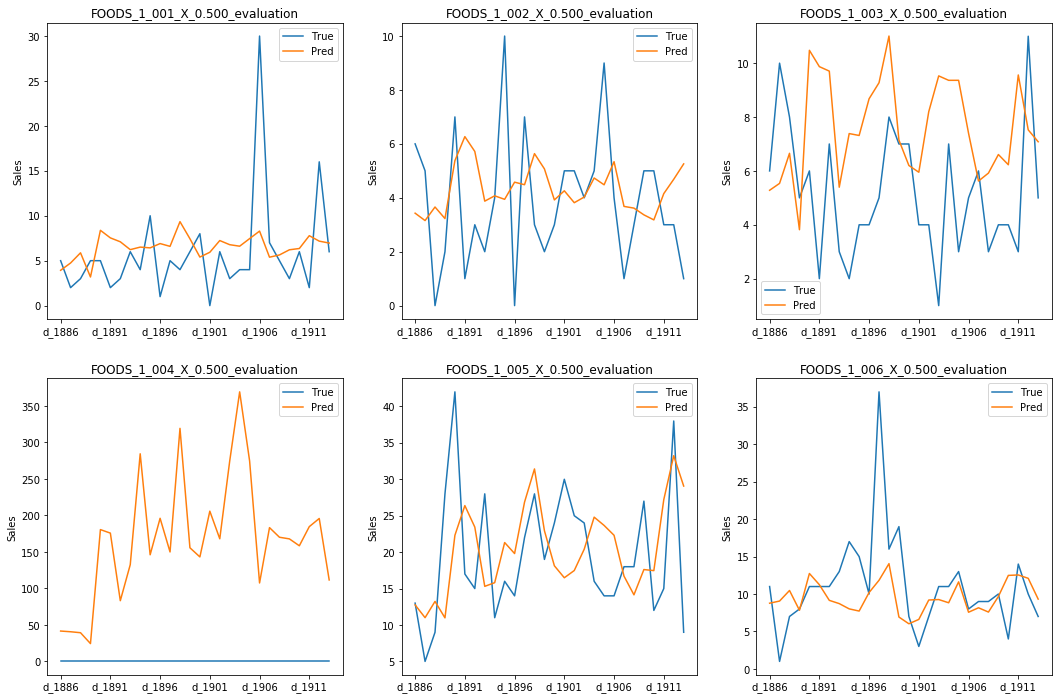

In [15]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

In [16]:
model.save(model_dir + '6yr_dist_epoch20.h5')
model.set_weights(logger.best_model)
model.save(model_dir + '6yr_dist_best_spl.h5')

## Train Dense(256, 9)

In [ ]:
# model setup
model = get_simple_dense_model(INP_SHAPE, num_nodes=256, bottleneck_nodes=9)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
model.summary()

# setup metric tracking
logger = Logger(val_batch_creator)
wandb.init(project='m5forecast', name="L10-dense-6yr")

# train model
history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger, WandbCallback()])

# calculate WSPL and save metrics
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

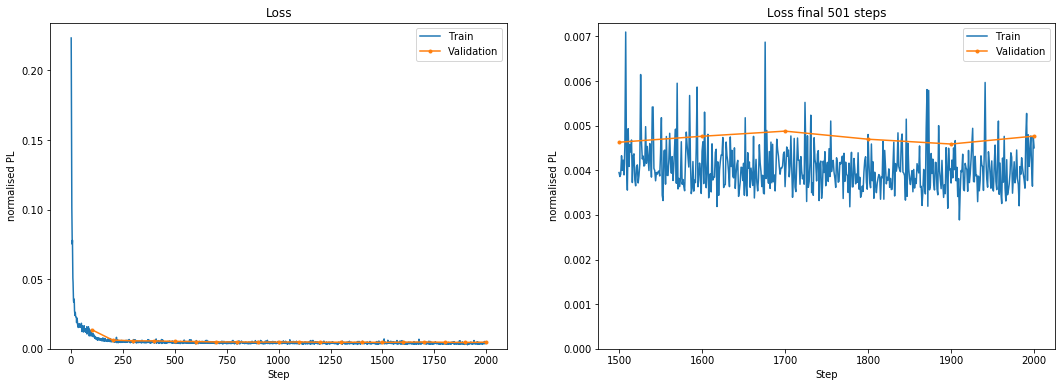

In [21]:
logger.plot()

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.220605289842538, 'WSPL': 0.220605289842538}


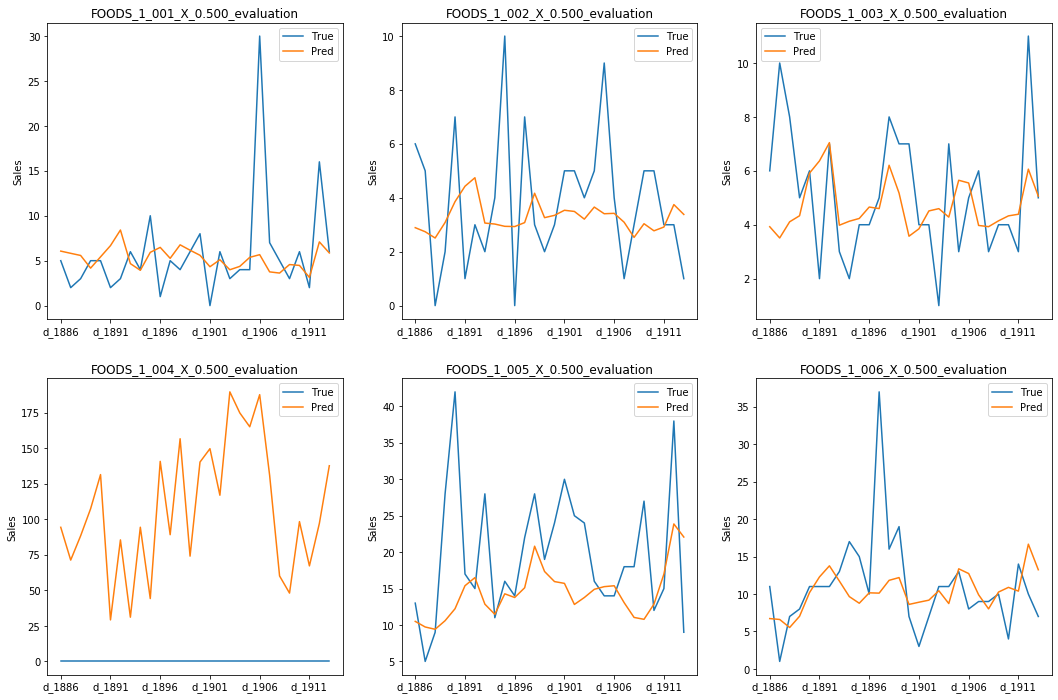

In [22]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

In [20]:
model.save(model_dir + '6yr_dist_epoch20.h5')
model.set_weights(logger.best_model)
model.save(model_dir + '6yr_dist_best_spl.h5')